# Proyecto final de Tópicos Avanzados de Ciencias de la Computación utilizando Pyspark

El objetivo de este proyecto es clasificar crimes de San Francisco en 33 categorías predefinidas basándonos en su descripción. Siendo la clasificación de un crimen para una sola de las categorias.
Los datos utilizados son de crimenes en San Francisco obtenidos de la página Kaggle https://www.kaggle.com/c/sf-crime/data.

Para cumplir este objetivo se utilizaran diferentes tecnicas de extraccion de información, asi como varios algoritmos de aprendizaje automático supervisado que vienen en la librerias Apache PySpark. 

In [1]:
from pyspark.sql import SQLContext # El punto de entrada a toda la funcionalidad en Spark SQL.
from pyspark import SparkContext # Representa la conexión a un clúster Spark y se puede usar para crear RDD en ese clúster.
import matplotlib.pyplot as plt # Libreria de python para graficar en 2D.
from pyspark.sql.functions import col 
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import nltk

Cargamos conjunto de datos de un archivo CSV con los paquetes Spark csv y creamos el un SQLContext a partir de el archivo train.csv.

Con un SQLContext, las aplicaciones pueden crear DataFrames desde un [RDD](https://jaceklaskowski.gitbooks.io/mastering-apache-spark/spark-rdd.html) existente, desde una tabla Hive o desde fuentes de datos.

In [2]:
sc = SparkContext.getOrCreate() 
sqlContext = SQLContext(sc)
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('train.csv')

El archivo train.csv que contiene las Siguientes columnas:
   - Dates - marca de tiempo del incidente del crimen
   - Category: categoría del incidente del delito (solo en train.csv). Esta es la variable objetivo que vas a predecir.
   - Descript: descripción detallada del incidente del crimen (solo en train.csv)
   - DayOfWeek - el día de la semana
   - PdDistrict - nombre del distrito del departamento de policía
   - Resolution: cómo se resolvió el incidente del crimen (solo en train.csv)
   - Address - la dirección aproximada de la calle del incidente del crimen
   - X - Longitud
   - Y - Latitud

In [3]:
print(data)

DataFrame[Dates: timestamp, Category: string, Descript: string, DayOfWeek: string, PdDistrict: string, Resolution: string, Address: string, X: double, Y: double]


Para el tipo de clasificación que se realizará solo se necesita saber la descripción de el crimen y su categoria, así se quitaran las columnas que no se necesitan.

In [4]:
drop_list = ['Dates', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']
data = data.select([column for column in data.columns if column not in drop_list])
# Mostramos el contenido de 15 renglones de las columnas que nos quedan después de quitar las columnas innecesarias.
data.show(15) 

+--------------+--------------------+
|      Category|            Descript|
+--------------+--------------------+
|      WARRANTS|      WARRANT ARREST|
|OTHER OFFENSES|TRAFFIC VIOLATION...|
|OTHER OFFENSES|TRAFFIC VIOLATION...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| VEHICLE THEFT|   STOLEN AUTOMOBILE|
| VEHICLE THEFT|   STOLEN AUTOMOBILE|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
| LARCENY/THEFT|PETTY THEFT FROM ...|
|OTHER OFFENSES|MISCELLANEOUS INV...|
|     VANDALISM|MALICIOUS MISCHIE...|
| LARCENY/THEFT|GRAND THEFT FROM ...|
|  NON-CRIMINAL|      FOUND PROPERTY|
+--------------+--------------------+
only showing top 15 rows



Se aplica la función printSchema() en los datos para que se impriman en un formato de árbol.

In [5]:
data.printSchema()

root
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)



Obtenemos la cantidad de veces que aparece cada categoría en el archivo train.csv y obtenemos un top 20 de las caterorías de crimen más comunes en San Francisco.

+--------------------+------+
|            Category| count|
+--------------------+------+
|       LARCENY/THEFT|174900|
|      OTHER OFFENSES|126182|
|        NON-CRIMINAL| 92304|
|             ASSAULT| 76876|
|       DRUG/NARCOTIC| 53971|
|       VEHICLE THEFT| 53781|
|           VANDALISM| 44725|
|            WARRANTS| 42214|
|            BURGLARY| 36755|
|      SUSPICIOUS OCC| 31414|
|      MISSING PERSON| 25989|
|             ROBBERY| 23000|
|               FRAUD| 16679|
|FORGERY/COUNTERFE...| 10609|
|     SECONDARY CODES|  9985|
|         WEAPON LAWS|  8555|
|        PROSTITUTION|  7484|
|            TRESPASS|  7326|
|     STOLEN PROPERTY|  4540|
|SEX OFFENSES FORC...|  4388|
+--------------------+------+
only showing top 20 rows



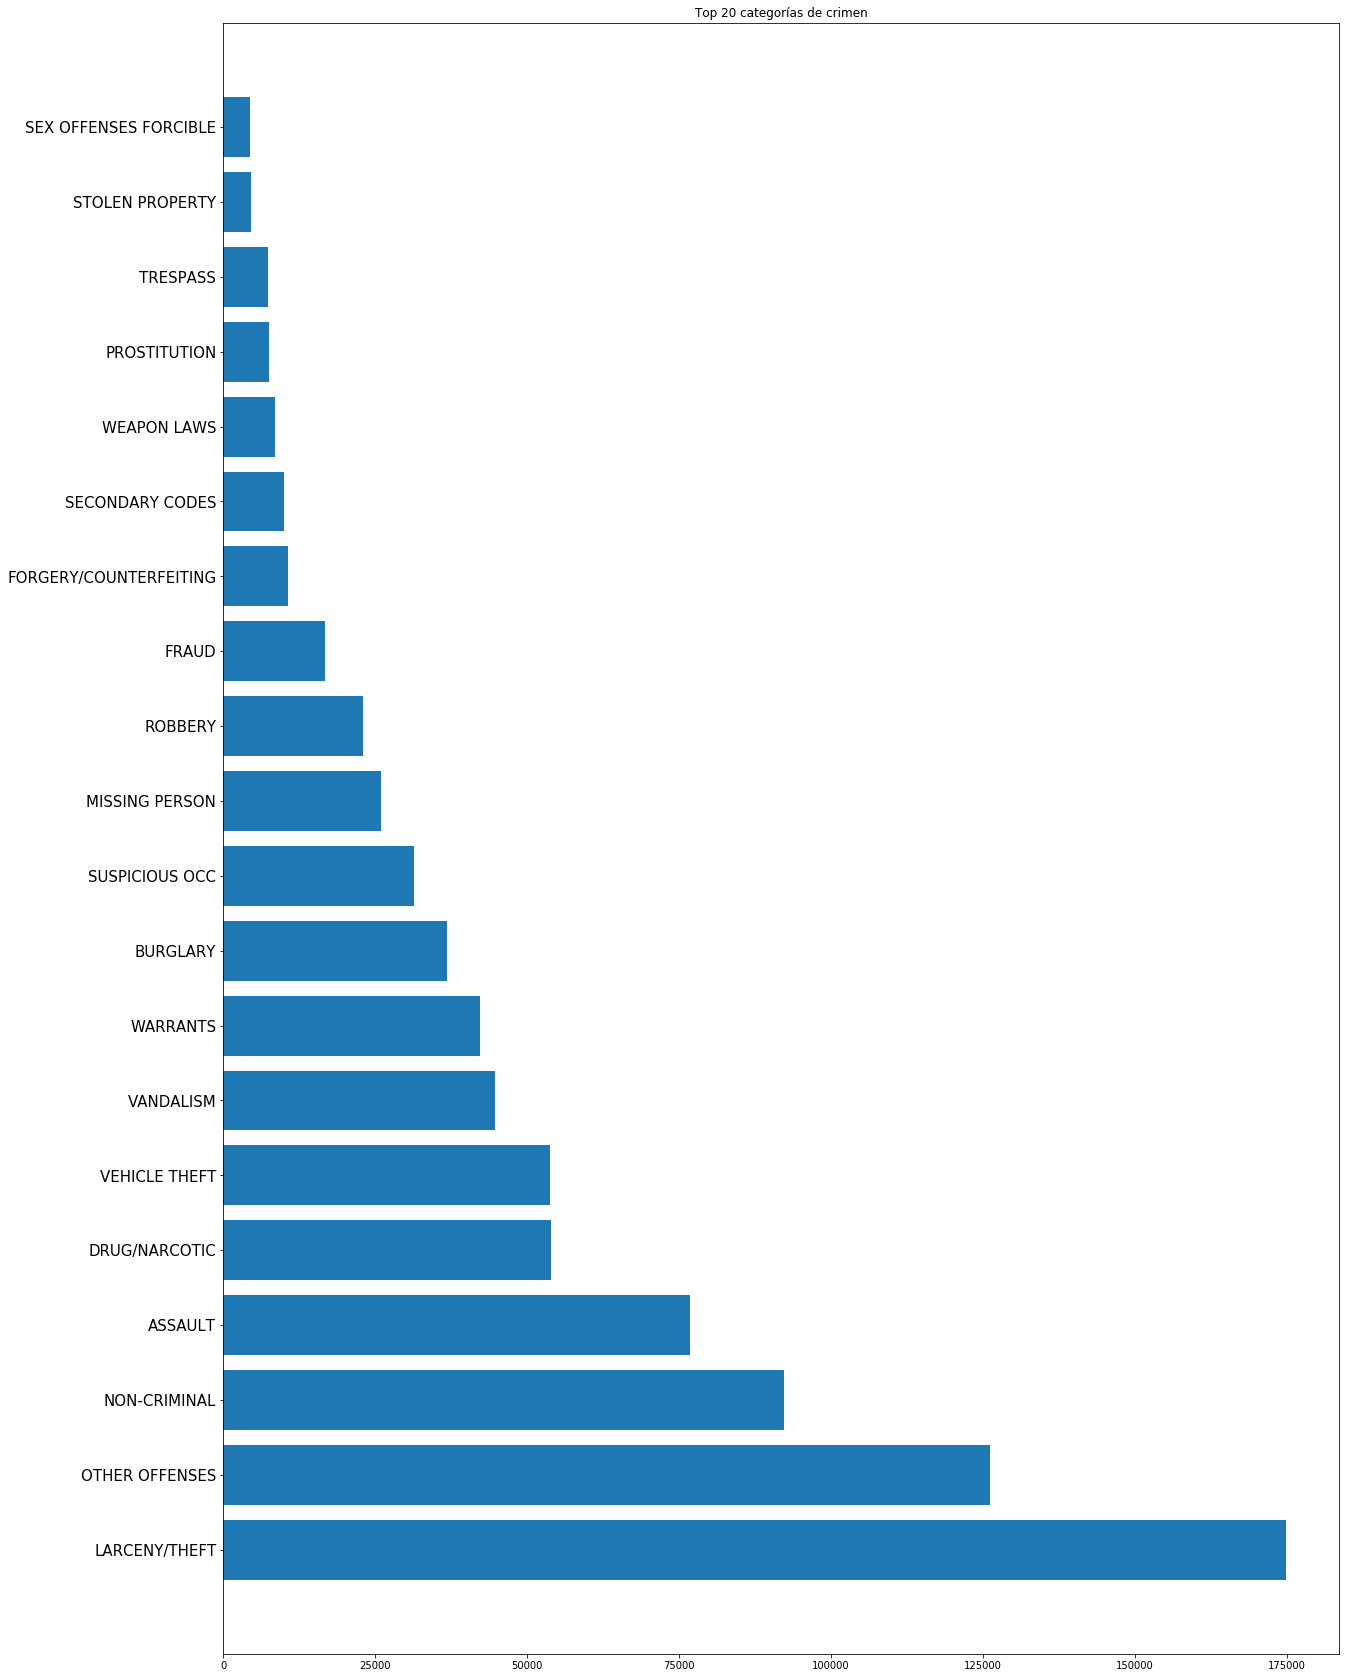

In [6]:
# Imprimimos los datos de la columna Category
data.groupBy("Category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()
# Seleccionamos la columna Descript dentro de nuestros datos y llenamos una lista con todas las categorías.
list_of_words = []
for cat in data.select("Category").collect():
    list_of_words.append(cat.Category)
    
# Utilizamos la libreria FreqDist para obtener la cantidad de veces que aparece cada categoría.
wordfreqdist = nltk.FreqDist(list_of_words)
mostcommon = wordfreqdist.most_common(20) #Obtenemos las 20 categorias más comunes, asi como la cantidad de veces que aparece.

# Gráfica de top 20 categorías 
plt.figure(figsize=(20,30))
plt.title('Top 20 categorías de crimen')
plt.barh(range(len(mostcommon)),[val[1] for val in mostcommon]) #Cantidad de veces que aparece la la categoría
plt.yticks(range(len(mostcommon)), [val[0] for val in mostcommon],fontsize=15) #Nombre de la categoría
plt.show()

Obtenemos la cantidad de descripción de cada crimen que contiene el archivo train.csv y obtenemos un top 20 de las descripciones de crimen más comunes en San Francisco.

+--------------------+-----+
|            Descript|count|
+--------------------+-----+
|GRAND THEFT FROM ...|60022|
|       LOST PROPERTY|31729|
|             BATTERY|27441|
|   STOLEN AUTOMOBILE|26897|
|DRIVERS LICENSE, ...|26839|
|      WARRANT ARREST|23754|
|SUSPICIOUS OCCURR...|21891|
|AIDED CASE, MENTA...|21497|
|PETTY THEFT FROM ...|19771|
|MALICIOUS MISCHIE...|17789|
|   TRAFFIC VIOLATION|16471|
|PETTY THEFT OF PR...|16196|
|MALICIOUS MISCHIE...|15957|
|THREATS AGAINST LIFE|14716|
|      FOUND PROPERTY|12146|
|ENROUTE TO OUTSID...|11470|
|GRAND THEFT OF PR...|11010|
|POSSESSION OF NAR...|10050|
|PETTY THEFT FROM ...|10029|
|PETTY THEFT SHOPL...| 9571|
+--------------------+-----+
only showing top 20 rows



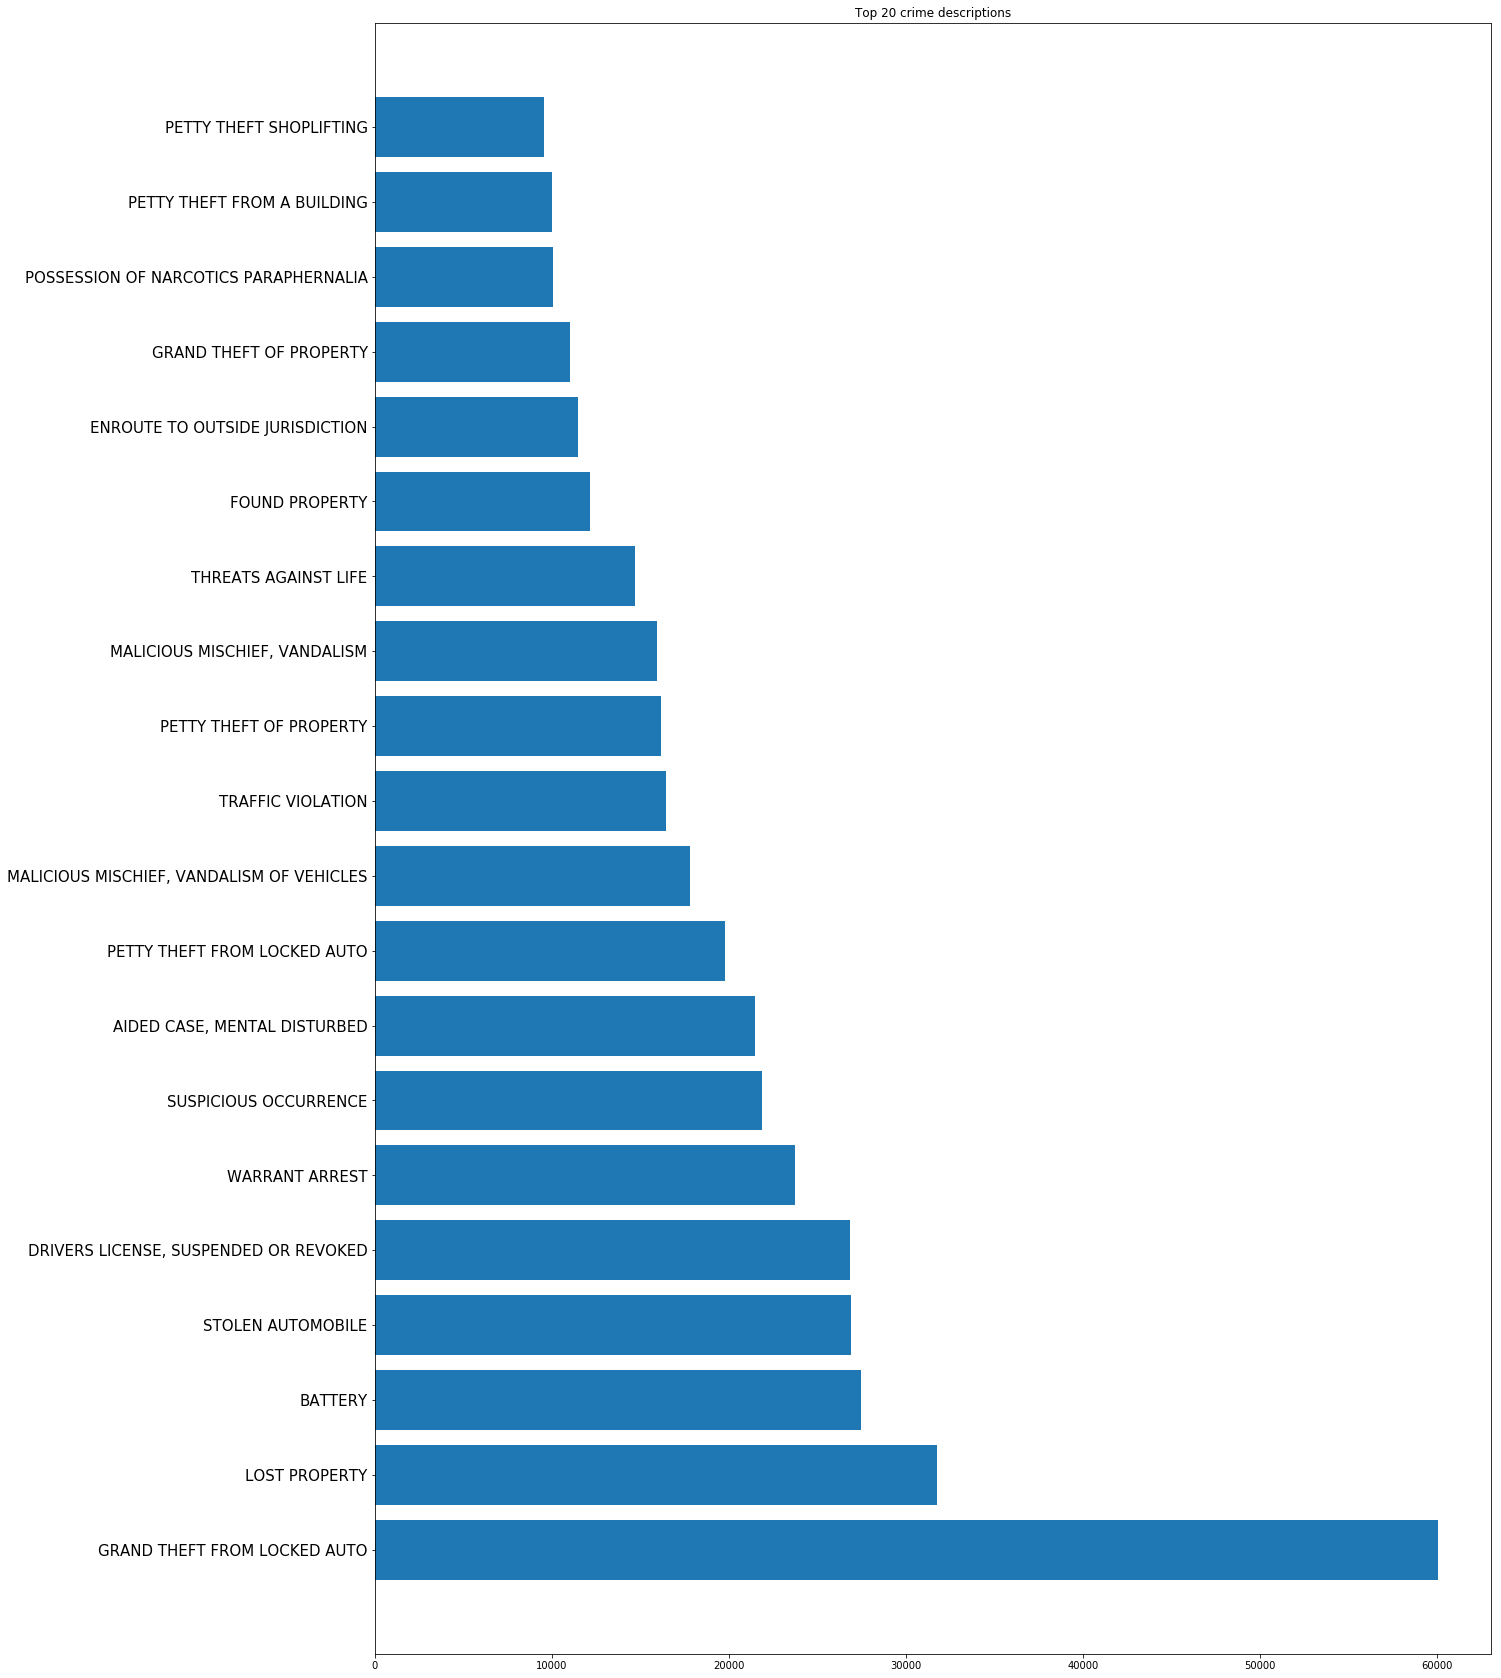

In [7]:
# Imprimimos los datos de la columna Descript
data.groupBy("Descript") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()
#Seleccionamos la columna Descript dentro de nuestros datos y llenamos una lista con todas las descripciones.
list_of_descriptions = []
for cat in data.select("Descript").collect():
    list_of_descriptions.append(cat.Descript)
    
# Utilizamos la libreria FreqDist para obtener la cantidad de veces que aparece cada descripción.
wordfreqdistD = nltk.FreqDist(list_of_descriptions)
mostcommonD = wordfreqdistD.most_common(20)

# Gráfica de top 20 descripciones.
plt.figure(figsize=(20,30))
plt.title('Top 20 crime descriptions')
plt.barh(range(len(mostcommonD)),[val[1] for val in mostcommonD])
plt.yticks(range(len(mostcommonD)), [val[0] for val in mostcommonD],fontsize=15)
plt.show()

## Modelo del Pipeline
Un canal de aprendizaje automático es un flujo de trabajo completo que combina varios algoritmos de aprendizaje automático. Puede haber muchos pasos necesarios para procesar y aprender de los datos, lo que requiere una secuencia de algoritmos.
Las [pipelines](https://spark.apache.org/docs/2.2.0/ml-pipeline.html) definen las etapas y el ordenamiento de un proceso de aprendizaje automático.
En [MLlib](https://spark.apache.org/docs/latest/ml-guide.html), las etapas de una tubería están representadas por una secuencia específica de PipelineStages, donde un transformador y un estimador realizan tareas.

 - Un transformador es un algoritmo que transforma un DataFrame en otro utilizando el método transform (). Por ejemplo, un transformador de características podría leer una columna de un DataFrame, asignarlo a otra columna,
y genere un nuevo DataFrame con la columna asignada adjunta.

 - Un estimador es una abstracción de algoritmos de aprendizaje, y es responsable de ajustar o entrenar en un conjunto de datos para producir un transformador. Un estimador implementa un método llamado fit (), que acepta un DataFrame y produceun DataFrame, que es un transformador.

La API de Spark Machine Learning Pipelines es similar a [Scikit-Learn](https://scikit-learn.org/0.19/index.html). El pipeline a utilizar en este programa incluye tres pasos:
1. regexTokenizer: Tokenización (con expresión regular)
2. stopwordsRemover: eliminar palabras de parada
3. countVectors: Count vectors (“vectores de término de documento”)


In [8]:
# Tokenizador de expresiones regulares
regexTokenizer = RegexTokenizer(inputCol="Descript", outputCol="words", pattern="\\W")
# Stop words o palabras de paro que se eliminaran 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(["http","https","amp","rt","t","c","the"])
# Recuento del bag of words (bolsa de palabras) 
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

[StringIndexer](https://spark.apache.org/docs/2.3.1/ml-features.html#stringindexer) codifica una columna de cadena de etiquetas en una columna de índices de etiquetas.
Los índices están en \[0, numLabels), ordenados por frecuencias de etiquetas, por lo que la etiqueta más frecuente obtiene el índice 0. En nuestro caso, la columna de etiqueta (Categoría) se codificará para etiquetar índices, de 0 a 32; La etiqueta más frecuente se indexará como 0.

In [9]:
label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
# Ajuste del pipeline a los documentos de entrenamiento.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      Category|            Descript|               words|            filtered|            features|label|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      WARRANTS|      WARRANT ARREST|   [warrant, arrest]|   [warrant, arrest]|(809,[17,32],[1.0...|  7.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|[traffic, violati...|[traffic, violati...|(809,[11,17,35],[...|  1.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|[traffic, violati...|[traffic, violati...|(809,[11,17,35],[...|  1.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|[grand, theft, fr...|[grand, theft, fr...|(809,[0,2,3,4,6],...|  0.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|[grand, theft, fr...|[grand, theft, fr...|(809,[0,2,3,4,6],...|  0.0|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



## Conjunto de entrenamiento y conjunto de datos de prueba 
Los datos se dividen en un conjunto de datos de entrenamiento y un conjunto de datos de prueba, el 70% de los datos se utiliza para entrenar el modelo y el 30% se usará para la prueba.

In [10]:
(trainingData, testData) = dataset.randomSplit([0.70, 0.30], seed = 100) 
print("Recuento de conjunto de datos de entrenamiento: " + str(trainingData.count()))
print("Recuento de conjunto de datos de prueba: " + str(testData.count()))

Recuento de conjunto de datos de entrenamiento: 614303
Recuento de conjunto de datos de prueba: 263746


## Modelo de Entrenamiento y Evaluación con Regresión Logística 
Para el primer modelo de entrenamiento utilizaremos [Regresión logística](https://es.wikipedia.org/wiki/Regresi%C3%B3n_log%C3%ADstica) usando las características del [vector de conteo](https://spark.apache.org/docs/2.1.0/ml-features.html#countvectorizer). Este modelo hará predicciones y dará una puntuación en el conjunto de pruebas; A partir de esto, observamos las 10 mejores predicciones con la probabilidad más alta.

In [11]:
logistic_regression = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0) 
logistic_regression_Model = logistic_regression.fit(trainingData) # Ajustamos el modelo
# A continuación utilizamos los datos de prueba para obtener las predicciones.
predictions = logistic_regression_Model.transform(testData) # Regresa la clasificación
# La transformación del modelo anterior produjo una nueva columna Prediction con: probabilidad(probability) y etiqueta(label). 
predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-------------+------------------------------+-----+----------+
|                      Descript|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785517561,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785517561,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785517561,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785517561,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785517561,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785517561,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8737986785517561,0.02009...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8

## Evaluación multiclase para Regresión logística
Evaluamos que tan buena fue la predicción de hecha con nuestro conjunto de entrenamiento y nuestro conjunto de prueba con el evaluador [MulticlassClassificationEvaluator](https://spark.apache.org/docs/2.2.0/api/java/org/apache/spark/ml/evaluation/MulticlassClassificationEvaluator.html) para la clasificación multiclase, que espera dos columnas de entrada: predicción y etiqueta. Este evalúa la salida del modelo y devuelve una métrica escalar. 

In [12]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Precisión de evaluación: ",(evaluator.evaluate(predictions) *100),"%")

Precisión de evaluación:  97.17430326832269 %


## Naive Bayes
Un [clasificador de Naive Bayes](https://es.wikipedia.org/wiki/Clasificador_bayesiano_ingenuo) asume que la presencia o ausencia de una característica particular no está relacionada con la presencia o ausencia de cualquier otra característica, dada la clase variable. Una ventaja del clasificador de Bayes ingenuo es que solo se requiere una pequeña cantidad de datos de entrenamiento para estimar los parámetros (las medias y las varianzas de las variables) necesarias para la clasificación.

In [13]:
naive_bayes = NaiveBayes(smoothing=1)
naive_bayes_Model = naive_bayes.fit(trainingData)
predictions = naive_bayes_Model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    #.show(n = 10, truncate = 30)

# Evaluamos el mejor modelo: 
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Precisión de evaluación para Naive Bayes: ",(evaluator.evaluate(predictions) *100),"%")

Precisión de evaluación para Naive Bayes:  99.37211787626278 %


## Cross-Validation
La [validación cruzada](https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada) es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que son independientes de la partición entre datos de entrenamiento y prueba. Consiste en repetir y calcular la media aritmética obtenida de las medidas de evaluación sobre diferentes particiones. Se utiliza en entornos donde el objetivo principal es la predicción y se quiere estimar la precisión de un modelo que se llevará a cabo a la práctica.
Con esta técnica solo ajustaremos los vectores del conteo con Regresión logística.

In [14]:
# Creamos un ParamGrid para construir una cuadrícula de parámetros para la validación cruzada
paramGrid = (ParamGridBuilder()
             .addGrid(logistic_regression.regParam, [0.1, 0.3, 0.5]) # Parámetro de regularización
             .addGrid(logistic_regression.elasticNetParam, [0.0, 0.1, 0.2]) # Parametro Elastic Net (Ridge = 0)
             .build())
# Creamos un CrossValidator con 5-fold 
cv = CrossValidator(estimator=logistic_regression, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)

# Evaluamos el mejor modelo para Cross Validation
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Precisión de evaluación con Cross Validation: ",(evaluator.evaluate(predictions) *100),"%")

Precisión de evaluación con Cross Validation:  99.1419899490691 %


## Random Forest 
Random forest también conocidos como ["Bosques Aleatorios"](https://es.wikipedia.org/wiki/Random_forest) es un método de aprendizaje conjunto para la clasificación, regresión y otras tareas que funcionan mediante la construcción de una multitud de árboles de decisión en el momento del entrenamiento y la salida de la clase que es el modo de las clases (clasificación) o la predicción de la media (regresión) De los árboles individuales. Los bosques de decisión aleatoria corrigen el hábito de los árboles de decisión de sobrealimentar a su conjunto de entrenamiento.

In [15]:
random_forest = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Entrenamos el modelo con los datos de entrenamiento.
random_forest_Model = random_forest.fit(trainingData)
predictions = random_forest_Model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    #.show(n = 10, truncate = 30)

#Evaluamos el mejor modelo:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Precisión de evaluación con Random Forest: ",(evaluator.evaluate(predictions) *100),"%")

Precisión de evaluación con Random Forest:  68.45272161814788 %


# Conclusión
Al obtener los resultados de cada evaluación podemos darnos cuenta que el modelo que se utilizo para naive bayes fue el que tuvo mayor precisión. Random forest, a pesar que puede ser un metodo muy bueno para cierto tipo de clasificación, queda corto en este caso al ser el tamaño de datos de prueba bajo con respecto al elevado tamaño de datos de entrenamiento.